In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from CustomLogisticRegression import CustomLogisticRegression

np.random.seed(1)

%matplotlib inline

In [2]:
# https://www.kaggle.com/uciml/mushroom-classification
mushrooms = pd.read_csv("data/large/mushrooms.csv")

In [3]:
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

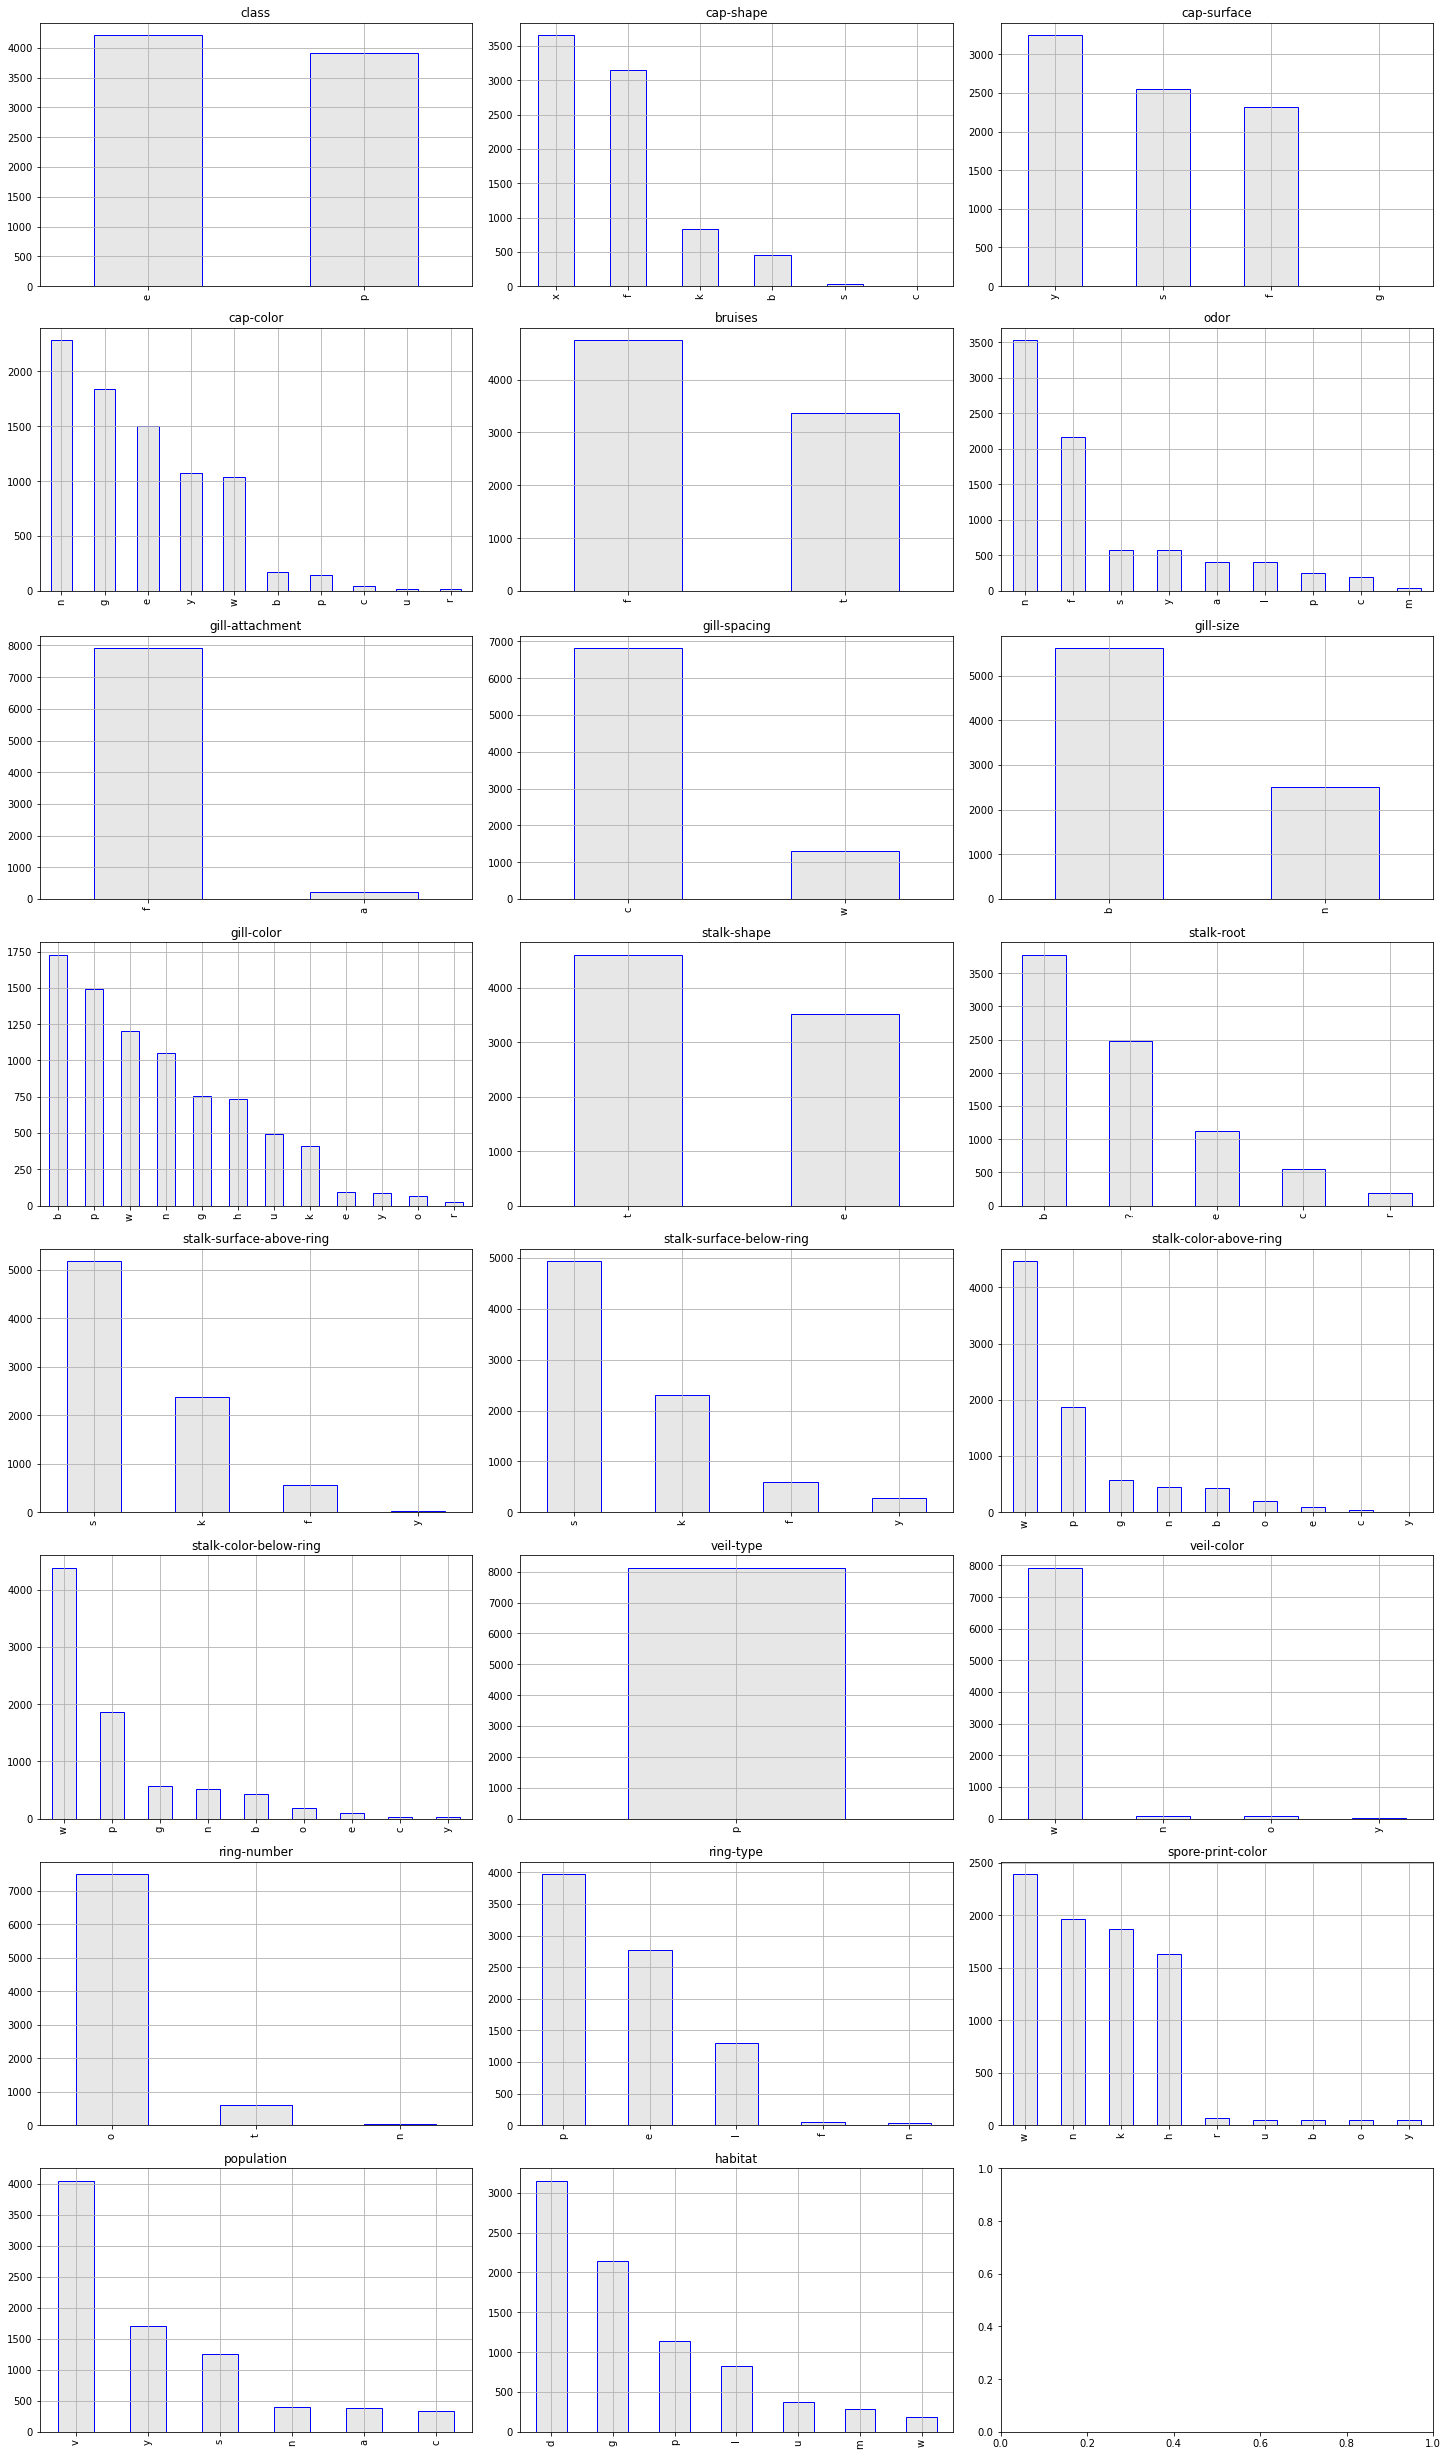

In [5]:
fig, ax = plt.subplots(mushrooms.shape[1]//3 + 1, 3, constrained_layout=True, figsize = (20,34))

for (i, column) in enumerate(mushrooms.columns):

    mushrooms[column].value_counts() \
        .plot(kind="bar", title=column, ax=ax[i//3, i%3], color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue', grid = True)


In [6]:
mushrooms.drop(['veil-type'], axis=1, inplace = True)

In [7]:
for column in mushrooms.columns:
    if len(mushrooms[column].value_counts()) == 2:
        le = LabelEncoder()
        mushrooms[column] = le.fit_transform(mushrooms[column])
        
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,1,0,1,k,...,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,1,a,1,0,0,k,...,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,1,l,1,0,0,n,...,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,1,p,1,0,1,n,...,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,0,n,1,1,0,k,...,s,s,w,w,w,o,e,n,a,g


In [8]:
corr = mushrooms.corr()
corr

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape
class,1.000000,-0.501530,0.129200,-0.348387,0.540024,-0.102019
bruises,-0.501530,1.000000,0.137359,-0.299473,-0.369596,0.099364
gill-attachment,0.129200,0.137359,1.000000,0.071489,0.108984,0.186485
gill-spacing,-0.348387,-0.299473,0.071489,1.000000,-0.108333,0.080895
gill-size,0.540024,-0.369596,0.108984,-0.108333,1.000000,0.214576
stalk-shape,-0.102019,0.099364,0.186485,0.080895,0.214576,1.000000


In [9]:
# Very interesting article about categorical "correlation"
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [10]:
cramersv = pd.DataFrame(np.zeros((mushrooms.shape[1], mushrooms.shape[1])), index=mushrooms.columns, columns=mushrooms.columns)

for col1 in mushrooms.columns:
    for col2 in mushrooms.columns:
        cramersv[col1][col2] = cramers_v(mushrooms[col1], mushrooms[col2])
   

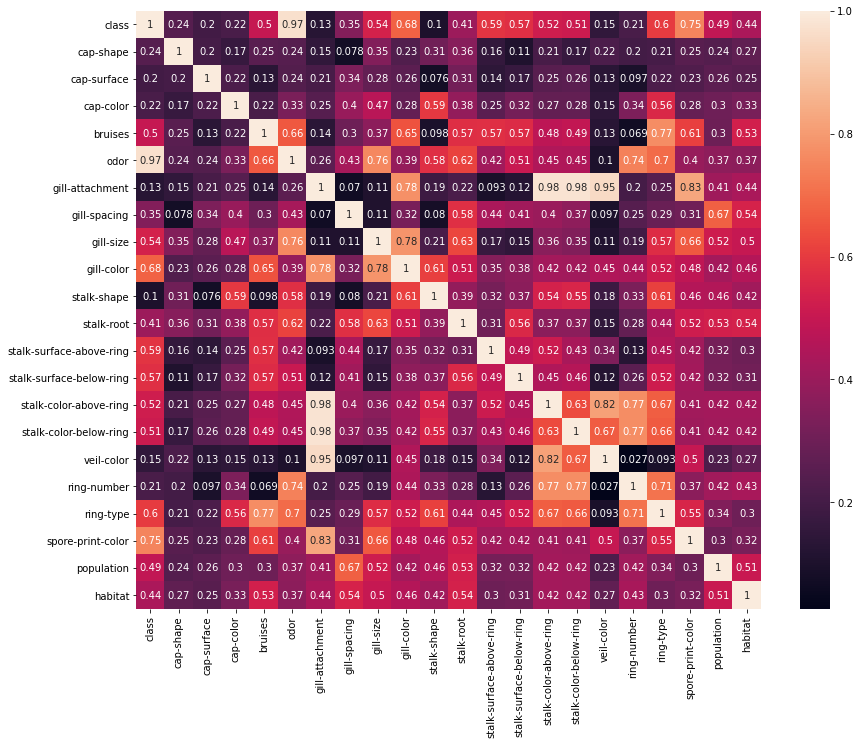

In [11]:
plt.figure(figsize=(14, 11))
sns.heatmap(cramersv, annot=True)

In [12]:
mushrooms = pd.get_dummies(mushrooms)
mushrooms.head()

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
X = mushrooms.drop(['class'], axis=1, inplace=False)

In [14]:
y = mushrooms['class']

# Model training & evaluation

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#####  Logistic Regression - custom algorithm:

In [16]:
clr = CustomLogisticRegression(learning_rate=0.01, num_iters=3000, normalize=True)

In [17]:
clr.fit(X_train, y_train)

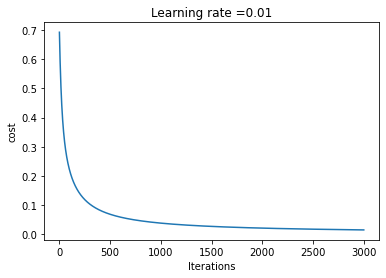

In [18]:
plt.plot(clr.J_history)
plt.ylabel('cost')
plt.xlabel('Iterations')
plt.title("Learning rate =" + str(clr.learning_rate))
plt.show()

In [19]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Train accurasy: ', accuracy_score(y_train, y_train_pred))
    print('Test accurasy: ', accuracy_score(y_test, y_test_pred))

In [20]:
evaluate(clr, X_train, X_test, y_train, y_test)

Train accurasy:  0.9998461301738729
Test accurasy:  0.9987692307692307


#####  Logistic Regression - sklearn:

In [21]:
lr = LogisticRegression(solver='lbfgs')

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
evaluate(lr, X_train, X_test, y_train, y_test)

Train accurasy:  0.9995383905216187
Test accurasy:  0.9981538461538462


# Features importance

In [24]:
coeff_df = pd.DataFrame(lr.coef_.reshape((111,)), X.columns, columns=['Coefficient'])
coeff_df = coeff_df.sort_values('Coefficient', ascending=0)

In [25]:
top = pd.concat([coeff_df.head(10), coeff_df.tail(10)])
top

,Coefficient
spore-print-color_r,3.598161
gill-size,3.093876
odor_c,2.776924
odor_f,2.579869
odor_p,2.533158
stalk-root_b,2.073665
gill-color_b,1.939872
stalk-surface-above-ring_k,1.669613
stalk-surface-below-ring_y,1.421211
population_c,1.139003


In [26]:
top = top.apply(np.abs)
top = top.sort_values('Coefficient', ascending=1)

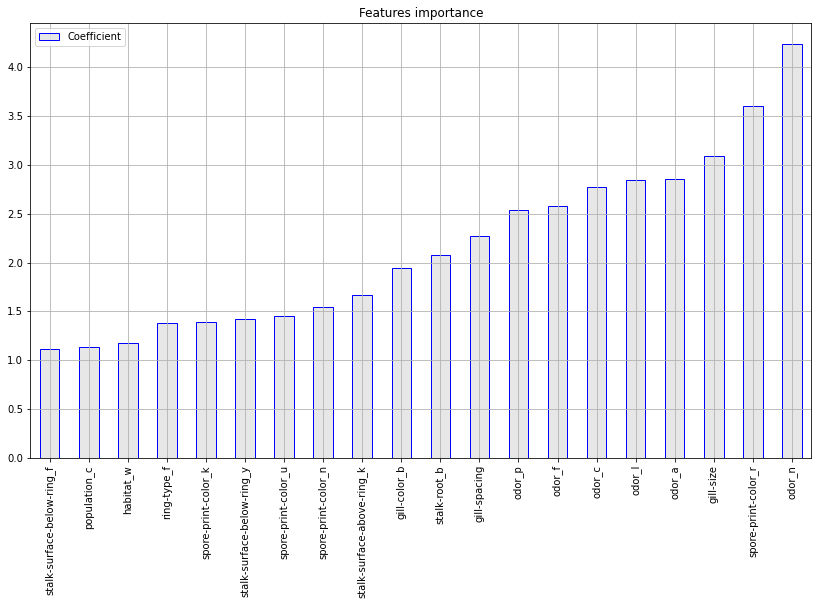

In [27]:
top.plot(kind='bar', title='Features importance', color=(0.1, 0.1, 0.1, 0.1),\
         edgecolor='blue', grid = True, figsize=(14, 8))